In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

# Load and prepare data

In [3]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = [
    "MMR",  # Myanmar
    "THA",  # Thailand
    "LAO",  # Laos
    "KHM",  # Cambodia
    "VNM",  # Vietnam
    "IDN",  # Indonesia
    "MYS",  # Malaysia
    # "SGP",  # Singapore
    "PHL",  # Philippines
    # "BRN",  # Brunei
    "TLS"   # Timor-Leste
]

laos_closest_neighboors = [
    "KHM",  # Cambodia
    "THA",  # Thailand
    "LAO",  # Laos
    "VNM",  # Vietnam
]

# Define maps
sea_map = world.query('ISO_A3 in @laos_neighboors')
laos_closest_map = world.query('ISO_A3 in @laos_closest_neighboors')
laos_map = world.query('ISO_A3 == "LAO"')

In [4]:
sea_point_grid = load_grid_point_data(region='sea', grid_size=400, force_reload = False )
laos_point_grid = load_grid_point_data(region='laos', grid_size=200, force_reload = False)
laos_closest_grid = load_grid_point_data(region='custom', grid_size=400, iso_list= laos_closest_neighboors, force_reload = False)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\sea_points_400.shp\sea_points_400.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_points_200.shp\laos_points_200.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\custom_points_400.shp\custom_points_400.shp.shp


In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()


In [11]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create SEA and Laos data sets

In [12]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )

# Create the geodata set for laos_closest
laos_closest_disasters = model_df.query('ISO in @laos_closest_neighboors  & is_disaster == 1')

laos_closest_disasters_geo = gpd.GeoDataFrame(
                laos_closest_disasters,
    geometry=gpd.points_from_xy(laos_closest_disasters["long"], laos_closest_disasters["lat"]), crs="EPSG:4326"
            )

# Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_closest_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

In [13]:
# Define dfs
sea_df = model_df.query('ISO in @laos_neighboors')
lao_closest_df = model_df.query('ISO in @laos_closest_neighboors')
lao_df = model_df.query('ISO == "LAO"')

#Tranform dfs to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")
lao_closest_df = gpd.GeoDataFrame(lao_closest_df,  geometry=gpd.points_from_xy(lao_closest_df["long"],
                                lao_closest_df["lat"]),crs="EPSG:4326")
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

In [14]:
# Merge geospatial data with time varying data
# We create the merged sea_point_grid_extended for predictions
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

country_2005_data = {}
country_2005_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2005_data[country] = sea_df.query('Start_Year == "2005-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2005_data_df = pd.concat([country_2005_data_df, country_2005_data[country]])

C:\Users\camil\AppData\Local\Temp\ipykernel_39132\2682428394.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_39132\2682428394.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_39132\2682428394.py:6: FutureWarning: The behavi

In [15]:
# Merge points with world ISO
sea_point_grid_extended = {}
sea_point_grid_extended_df = gpd.sjoin(sea_point_grid, sea_map, how="left", )
sea_point_grid_extended["2020"] = pd.merge(sea_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 
sea_point_grid_extended["2005"] = pd.merge(sea_point_grid_extended_df, country_2005_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

# Merge points with world ISO
laos_closest_point_grid_extended = {}
laos_closest_point_grid_extended_df = gpd.sjoin(laos_closest_grid, laos_closest_map, how="left", )
laos_closest_point_grid_extended["2020"] = pd.merge(laos_closest_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 
laos_closest_point_grid_extended["2005"] = pd.merge(laos_closest_point_grid_extended_df, country_2005_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" )

# Creating the laos_point_grid_extended
laos_point_grid["ISO"] = "LAO"
laos_point_grid_extended = {}
laos_point_grid_extended_df = gpd.sjoin(laos_point_grid, laos_map, how="left", )
laos_point_grid_extended["2020"] = pd.merge(laos_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 
laos_point_grid_extended["2005"] = pd.merge(laos_point_grid_extended_df, country_2005_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 


In [16]:
# Standardize SEA data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

# other dfs
sea_point_grid_extended["2020"] = transformer_stand_.transform(sea_point_grid_extended["2020"]) 
sea_point_grid_extended["2005"] = transformer_stand_.transform(sea_point_grid_extended["2005"]) 

laos_closest_point_grid_extended["2020"] = transformer_stand_.transform(laos_closest_point_grid_extended["2020"]) 
laos_closest_point_grid_extended["2005"] = transformer_stand_.transform(laos_closest_point_grid_extended["2020"]) 

laos_point_grid_extended["2020"] = transformer_stand_.transform(laos_point_grid_extended["2020"]) 
laos_point_grid_extended["2005"] = transformer_stand_.transform(laos_point_grid_extended["2005"])

In [17]:
# Center grids

# Model on the SEA data set: HSGP component

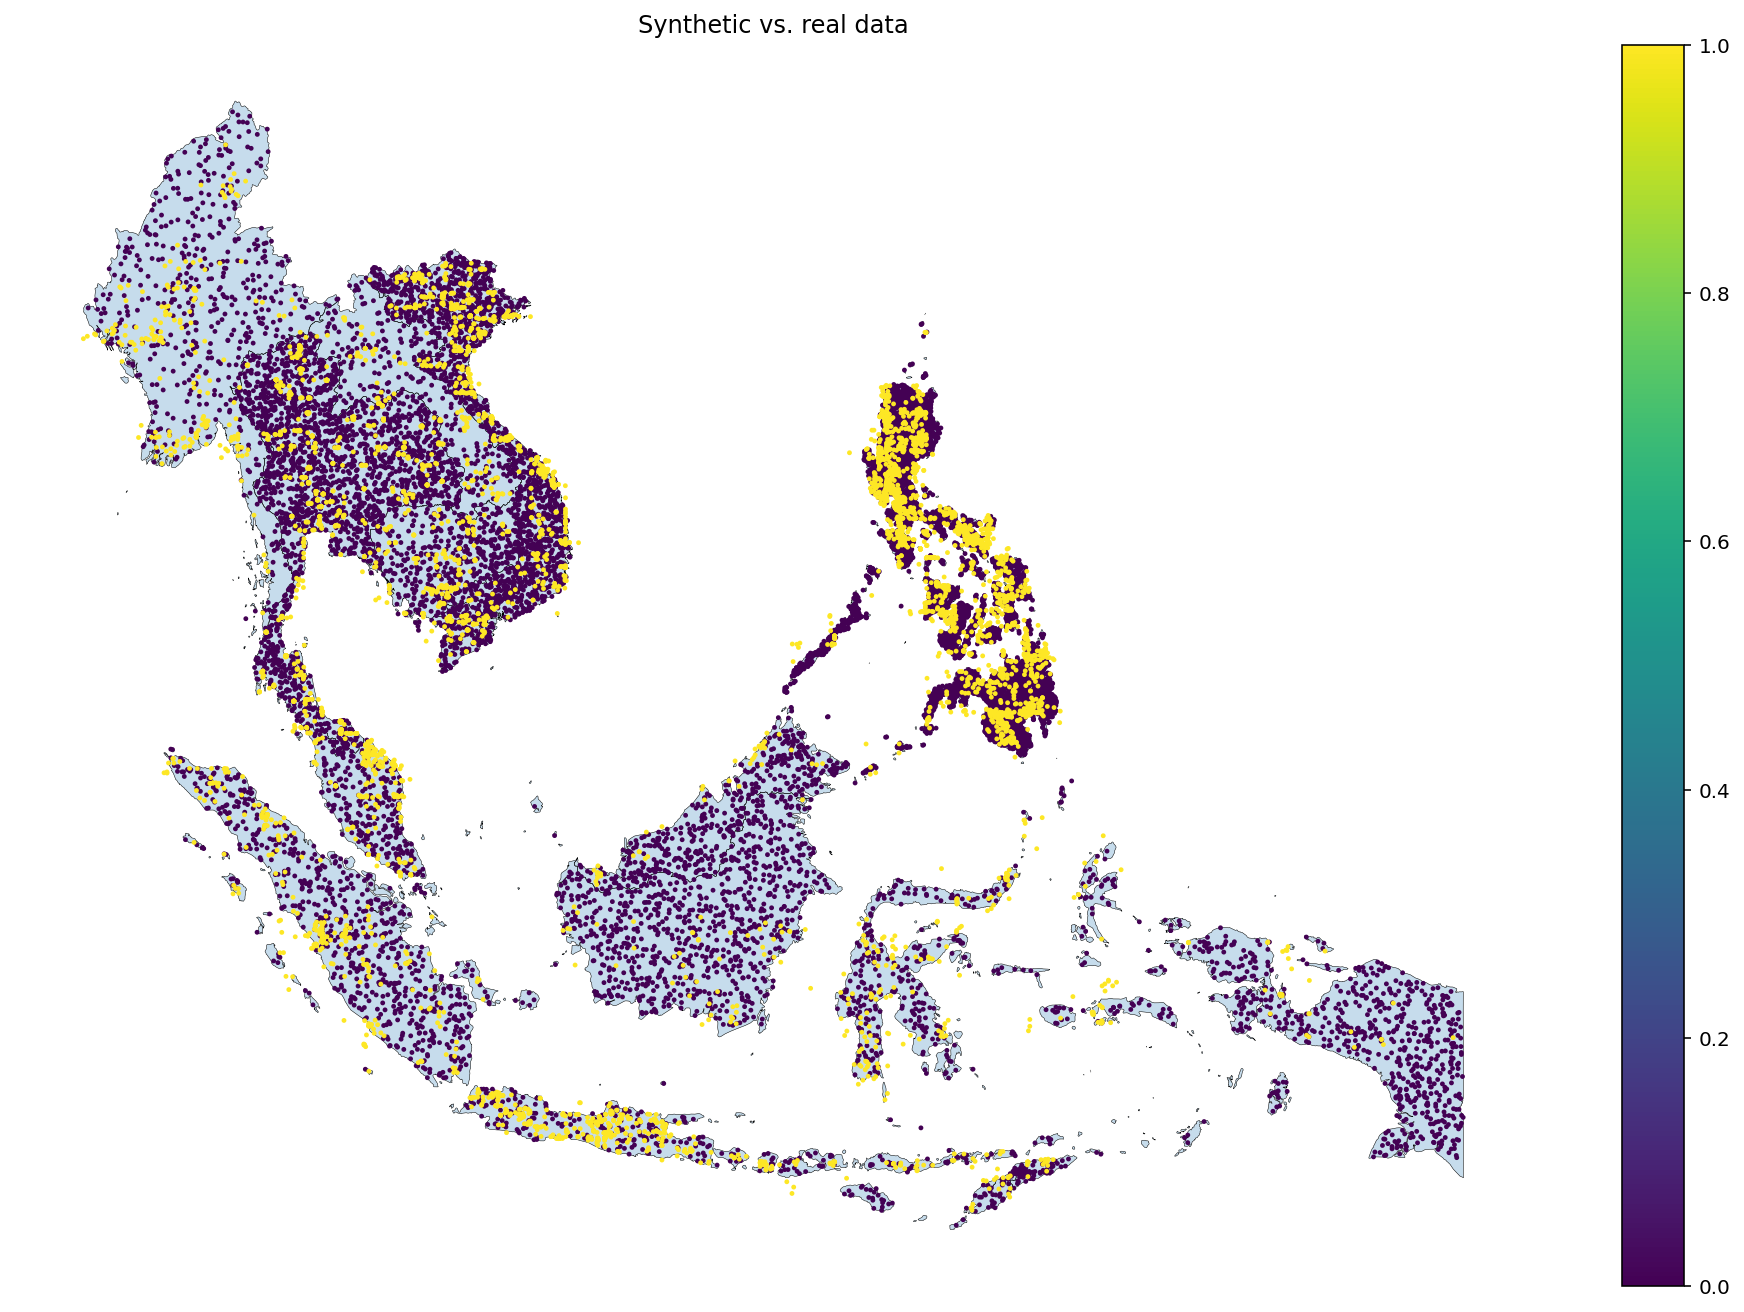

In [18]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

sea_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [19]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(sea_df["is_disaster"])
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 
obs_idx = sea_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(sea_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sea = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [20]:
with pm.Model(coords=coords_sea) as model_sea_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df_stand[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    
    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    p = HSGP_component
    
    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')


C:\Users\camil\AppData\Local\Temp\ipykernel_39132\2324413867.py:10: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [ ]:
# Sample the model
if exists("model_sea_HSGP.idata"):
    model_sea_hsgp_idata = az.from_netcdf("model_sea_HSGP.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_hsgp), backend="jax", gradient_backend='jax')
    model_sea_hsgp_idata = nutpie.sample(compiled_model)
    #Save the idata
    az.to_netcdf(data = model_sea_hsgp_idata, filename= pathlib.Path("model_sea_HSGP.idata"))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,131,0,0.10,127
,172,0,0.08,127
,143,0,0.04,255
,130,0,0.07,255
,124,0,0.04,255
,139,0,0.07,255


### Sea predictions

In [ ]:
# We sample the predictions
with model_sea_hsgp.copy() as temp_model:
    pm.set_data({"X_gp": sea_point_grid[["lat", "lon"]],
                 "Y": np.full(sea_df_stand.shape[0], 0 ),
                },
            coords= {"obs_idx": sea_df_stand.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))



with freeze_dims_and_data(temp_model):
    model_sea_hsgp_idata_plot = pm.sample_posterior_predictive(model_sea_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

In [ ]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_idata_plot , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = sea_point_grid )

In [ ]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
sea_model_HSGP_predictions["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =1)
sea_disasters.plot(ax=ax, alpha = 0.3, c = "r",markersize =0.7, )
plt.title("sea_model HSGP_invlogit" )
ax.set_title("sea_model HSGP_invlogit for South-East-Asia" );

### Laos_closest predictions

In [ ]:
# We sample the predictions
with model_sea_hsgp.copy() as temp_model:
    pm.set_data({"X_gp": laos_closest_grid[["lat", "lon"]],
                 "X": laos_closest_point_grid_extended["2020"] [features_stand],
                 "Y": np.full(laos_closest_grid.shape[0], 0 ),
                 
                },
            coords= {"obs_idx": laos_closest_grid.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))



with freeze_dims_and_data(temp_model):
    model_sea_hsgp_idata_plot_closest = pm.sample_posterior_predictive(model_sea_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

In [ ]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions_closest = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_idata_plot_closest , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = laos_closest_grid )

In [ ]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
sea_model_HSGP_predictions_closest["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =2)
laos_closest_disasters.plot(ax=ax, alpha = 0.3, c = "r",markersize =0.7, )
plt.title("sea_model HSGP_invlogit" )
ax.set_title("sea_model HSGP_invlogit for South-East-Asia" );

### Laos predictions

In [ ]:
# We sample the predictions
with model_sea_hsgp.copy() as temp_model:
    pm.set_data({"X_gp": laos_point_grid[["lat", "lon"]],
                 "X": laos_point_grid_extended["2020"][features_stand],
                 "Y": np.full(laos_point_grid.shape[0], 0 ),
                 
                },
            coords= {"obs_idx": laos_point_grid.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))



with freeze_dims_and_data(temp_model):
    model_sea_hsgp_idata_plot_laos = pm.sample_posterior_predictive(model_sea_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

In [ ]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions_lao = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_idata_plot_laos , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = laos_point_grid )

In [ ]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(8, 4), dpi= 144 )
sea_model_HSGP_predictions_lao["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax ,markersize =5, vmax = 0.4)
laos_disasters.plot(ax=ax, alpha = 0.3, c = "r",markersize =3, )
ax.set_title("sea_model HSGP_invlogit for Laos" );

# Model on the SEA data set: Full model

In [ ]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    ISO_idx_pt = pm.Data("ISO_idx_pt", ISO_idx, dims= ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd),dims= ["obs_idx"])


    #Model mu
    mu = pm.Deterministic("mu", country_effect[ISO_idx_pt] +  X@beta + HSGP_component , dims= ["obs_idx"] )
    

    y_hat = pm.Bernoulli('y_hat', logit_p = mu, observed=Y, dims=['obs_idx'])

In [ ]:
if exists("model_sea_full.idata"):
    model_sea_full_idata = az.from_netcdf("model_sea_full.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_full), backend="jax", gradient_backend='jax')
    model_sea_full_idata = nutpie.sample(compiled_model)
    #Save the idata
    az.to_netcdf(data = model_sea_full_idata, filename= pathlib.Path("model_sea_full.idata"))

### SEA predictions

In [ ]:
# full model SEA predictions

# Rebuild ISO_idx_sea
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_sea=  sea_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

with model_sea_full.copy() as temp_model:
    #Declare data
    pm.set_data({"X_gp": sea_point_grid[["lat", "lon"]],
                 "Y": np.full(sea_point_grid_extended['2020'].shape[0], 0 ),
                 "X": sea_point_grid_extended['2020'][features_stand],
                 "ISO_idx_pt": ISO_idx_sea
 
            },
        coords= {"obs_idx": sea_point_grid_extended['2020'].index.values } 
       )

    y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))



with freeze_dims_and_data(temp_model):
    model_sea_full_idata_plot = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                         compile_kwargs= {"mode" : "JAX" })


In [ ]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo = prediction_to_gpd_df(prediction_idata = model_sea_full_idata_plot , 
                     variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                     points = sea_point_grid_extended['2020'] )

In [ ]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_sea_full_predictions_geo["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =2, vmax = 0.15,)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r", markersize =0.7, )
plt.title("y_hat_invlogit South East Asia", );

### Laos closest prediction

In [ ]:
# full model SEA predictions

# Rebuild ISO_idx_sea
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_closest =  laos_closest_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

with model_sea_full.copy() as temp_model:
    #Declare data
    pm.set_data({"X_gp": laos_closest_grid[["lat", "lon"]],
                 "Y": np.full(laos_closest_point_grid_extended['2020'].shape[0], 0 ),
                 "X": laos_closest_point_grid_extended['2020'][features_stand],
                 "ISO_idx_pt": ISO_idx_closest
 
            },
        coords= {"obs_idx": laos_closest_point_grid_extended['2020'].index.values } 
       )

    y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))



with freeze_dims_and_data(temp_model):
    model_sea_full_idata_plot_closest = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                         compile_kwargs= {"mode" : "JAX" })


In [ ]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo_closest = prediction_to_gpd_df(prediction_idata = model_sea_full_idata_plot_closest , 
                     variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                     points = laos_closest_point_grid_extended['2020'] )

In [ ]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_sea_full_predictions_geo_closest["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =2, vmax = 0.2,)
laos_closest_disasters.plot(ax=ax, alpha = 0.3, c = "r", markersize =0.7, )
plt.title("For Laos neighboors", );

### Laos predictions

In [ ]:
# full model SEA predictions

# Rebuild ISO_idx_sea
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_laos =  laos_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

with model_sea_full.copy() as temp_model:
    #Declare data
    pm.set_data({"X_gp": laos_point_grid[["lat", "lon"]],
                 "Y": np.full(laos_point_grid_extended['2020'].shape[0], 0 ),
                 "X": laos_point_grid_extended['2020'][features_stand],
                 "ISO_idx_pt": ISO_idx_laos
 
            },
        coords= {"obs_idx": laos_point_grid_extended['2020'].index.values } 
       )

    y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))



with freeze_dims_and_data(temp_model):
    model_sea_full_idata_plot_laos = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                         compile_kwargs= {"mode" : "JAX" })


In [ ]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo_laos = prediction_to_gpd_df(prediction_idata = model_sea_full_idata_plot_laos , 
                     variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                     points = laos_point_grid_extended['2020'] )

In [ ]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(8, 4), dpi= 144 )
model_sea_full_predictions_geo_laos["HSGP_component"].plot("HSGP_component",legend=True, ax=ax,markersize =4, vmax = 0.15,)
laos_disasters.plot(ax=ax, alpha = 0.3, c = "r", markersize =2, )
plt.title("For Laos neighboors", );

In [ ]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(8, 4), dpi= 144 )
model_sea_full_predictions_geo_laos["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =4, vmax = 0.15,)
laos_disasters.plot(ax=ax, alpha = 0.3, c = "r", markersize =2, )
plt.title("For Laos neighboors", );